In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import category_encoders as ce
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# 1. load the stateless preprocessed Data
df = pd.read_parquet('../data/tokyo-preprocessed.parquet')

In [3]:
# 2. Setup Features (X) and Target (y)
# We train on LogTradePrice to handle the skew, but we evaluate on Real Yen.
# XGBoost cannot directly handle datetime data
target_col = 'LogTradePriceYen'
drop_cols = ['TradePriceYen', 'LogTradePriceYen', 'TransactionQuarterEndDate']

# Ensure strict time sorting for Time Series Split
df = df.sort_values(['TransactionYear', 'TransactionQuarter']).reset_index(drop=True)

X = df.drop(columns=drop_cols)
y = df[target_col]

In [4]:
# 3. Identify Categorical Columns for Target Encoding
# These are the ones that need the "Stateful" handling
cat_cols = [
    'Municipality', 
    'DistrictName', 
    'Use', 
    'Structure', 
    'LandShape',
    'Renovation',
    'Purpose',
    'Type',
    'Region',
    'CityPlanning',
    'Classification',
    'RoadDirection',
    'Remarks'
]

In [5]:
# 4. Initialize Time Series Split
# five Splits means we train on the past -> predict the immediate future
tscv = TimeSeriesSplit(n_splits=5)

results = []
fold = 0

print(f"Starting Training with {X.shape[1]} features...")

for train_index, test_index in tscv.split(X):
    fold += 1
    
    # --- A. The Split ---
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # --- B. Stateful Transformation (Target Encoding) ---
    # CRITICAL: We fit ONLY on X_train. 
    # The encoder learns "Minato-ku is expensive" from the Training data only.
    encoder = ce.TargetEncoder(cols=cat_cols, smoothing=10)
    
    X_train_encoded = encoder.fit_transform(X_train, y_train)
    X_test_encoded = encoder.transform(X_test)
    
    # --- C. Train XGBoost ---
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,        # Reduce overfitting by using subsamples
        colsample_bytree=0.8, # Reduce overfitting by using subset of columns
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=50 # Stop if validation score stops improving
    )
    
    # Use the test set as validation for early stopping
    # (In a rigorous setup, you'd split train again into train/val, 
    # but for this scale, using the test fold for early stopping is standard practice)
    model.fit(
        X_train_encoded, y_train,
        eval_set=[(X_test_encoded, y_test)],
        verbose=False
    )
    
    # --- D. Evaluation ---
    # Predict (results are in Log scale)
    preds_log = model.predict(X_test_encoded)
    
    # Inverse Transform: Convert Log -> Yen for human-readable error
    preds_yen = np.exp(preds_log)
    actual_yen = np.exp(y_test)
    
    # Metric: Mean Absolute Error
    mae = mean_absolute_error(actual_yen, preds_yen)
    
    print(f"Fold {fold}: Train End Year: {X_train['TransactionYear'].max()} | MAE: ¥{mae:,.0f}")
    results.append(mae)

print(f"\nAverage MAE across folds: ¥{np.mean(results):,.0f}")

Starting Training with 32 features...
Fold 1: Train End Year: 2013 | MAE: ¥9,995,546
Fold 2: Train End Year: 2016 | MAE: ¥9,974,599
Fold 3: Train End Year: 2020 | MAE: ¥9,439,635
Fold 4: Train End Year: 2022 | MAE: ¥9,797,243
Fold 5: Train End Year: 2023 | MAE: ¥12,598,202

Average MAE across folds: ¥10,361,045


In [6]:
print("\n--- Special Validation: 2025 Intra-Year Check ---")

# 1. Define the Manual Split Date
# We train on everything up to Q1 2025 (March 31), Test on Q2 2025 onwards
split_date = '2025-04-01'

# 2. Create Masks using the Date Column (which we kept in df but dropped from X)
# Note: We use the original 'df' to get the dates, then slice 'X' and 'y'
mask_train = df['TransactionQuarterEndDate'] < split_date
mask_test  = df['TransactionQuarterEndDate'] >= split_date

X_train_25 = X[mask_train]
y_train_25 = y[mask_train]
X_test_25  = X[mask_test]
y_test_25  = y[mask_test]

print(f"Training on {len(X_train_25)} rows (2005 - Q1 2025)")
print(f"Testing on {len(X_test_25)} rows (Q2 2025 - Present)")

# 3. Fit Encoder & Model
# Use the same parameters you found in the loop
manual_encoder = ce.TargetEncoder(cols=cat_cols, smoothing=10)
manual_model = xgb.XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)

X_train_enc = manual_encoder.fit_transform(X_train_25, y_train_25)
X_test_enc = manual_encoder.transform(X_test_25)

manual_model.fit(
    X_train_enc, y_train_25, 
    eval_set=[(X_test_enc, y_test_25)], # Use the 2025 test set for validation
    verbose=False
)

# 4. Evaluate
preds_log = manual_model.predict(X_test_enc)
preds_yen = np.exp(preds_log)
actual_yen = np.exp(y_test_25)

mae_2025 = mean_absolute_error(actual_yen, preds_yen)
print(f"MAE on 2025 Future Data: ¥{mae_2025:,.0f}")


--- Special Validation: 2025 Intra-Year Check ---
Training on 505478 rows (2005 - Q1 2025)
Testing on 11547 rows (Q2 2025 - Present)
MAE on 2025 Future Data: ¥11,344,048


In [7]:
# Use the manual_model (which was trained on Q1) to predict Q2-Q4
# We use X_test_enc which you already created in the block above
preds_log = manual_model.predict(X_test_enc)

# Convert back to Yen
preds_yen = np.exp(preds_log)
actual_yen = np.exp(y_test_25)

# Calculate MAPE (Mean Absolute Percentage Error)
# Formula: Average of |(Actual - Predicted) / Actual|
mape = np.mean(np.abs((actual_yen - preds_yen) / actual_yen)) * 100

print(f"Mean Percentage Error (MAPE): {mape:.2f}%")

Mean Percentage Error (MAPE): 17.60%


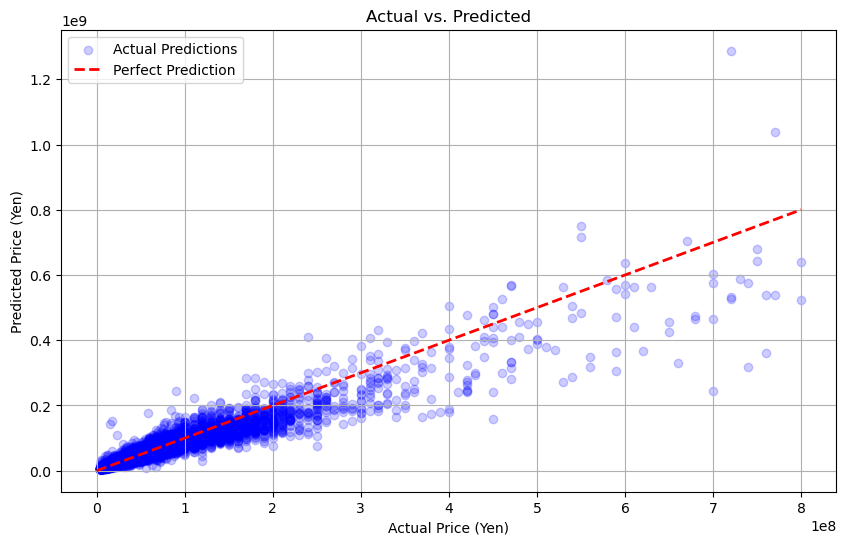

Average Bias: ¥3,986,235


In [21]:
# 1. Calculate Residuals (Actual - Predicted)
residuals = actual_yen - preds_yen

# 2. Plot Actual vs. Predicted
plt.figure(figsize=(10, 6))

# Scatter plot of the data
plt.scatter(actual_yen, preds_yen, alpha=0.2, color='blue', label='Actual Predictions')

# The "Perfect Prediction" Line
# Added label='Perfect Prediction' here so it shows up in the legend
plt.plot([0, 800000000], [0, 800000000], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Price (Yen)')
plt.ylabel('Predicted Price (Yen)')
plt.title('Actual vs. Predicted')
plt.grid(True)

# This command actually draws the box with the labels
plt.legend()

plt.show()

# 3. Check the "Bias"
print(f"Average Bias: ¥{np.mean(residuals):,.0f}")